# Task 1: Load the world



In [3]:
import pandas as pd

# Load the dataset
df = pd.read_csv('UCI_Real_Estate_Valuation.csv')

# Preview the dataset
df.head()


,No,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area
0,1,2012.917,32.0,84.87882,10,24.98298,121.54024,37.9
1,2,2012.917,19.5,306.59470,9,24.98034,121.53951,42.2
2,3,2013.583,13.3,561.98450,5,24.98746,121.54391,47.3
3,4,2013.500,13.3,561.98450,5,24.98746,121.54391,54.8
4,5,2012.833,5.0,390.56840,5,24.97937,121.54245,43.1


# Task 2: Preprocess the Dataset

In [5]:
# Remove duplicate rows, if any
df = df.drop_duplicates()

# Handle missing values 
df = df.fillna(df.mean())  # Filling missing values with mean for simplicity

# Feature scaling (standardization) except for the target variable 'Y house price of unit area'
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_features = scaler.fit_transform(df.drop(['Y house price of unit area'], axis=1))
scaled_df = pd.DataFrame(scaled_features, columns=df.columns[:-1])

# Add the target column back
scaled_df['Y house price of unit area'] = df['Y house price of unit area']



# Task 3: Split the Dataset

In [6]:
from sklearn.model_selection import train_test_split

# Define features (X) and target (y)
X = scaled_df.drop('Y house price of unit area', axis=1)
y = scaled_df['Y house price of unit area']

# Split data into train (70%), validation (15%), and test (15%) sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f'Training set: {X_train.shape}, Validation set: {X_val.shape}, Test set: {X_test.shape}')


Training set: (289, 7), Validation set: (62, 7), Test set: (63, 7)


# Task 4: Train SVR Models

In [7]:
from sklearn.svm import SVR

# Polynomial kernel SVR
svr_poly = SVR(kernel='poly')
svr_poly.fit(X_train, y_train)

# RBF kernel SVR
svr_rbf = SVR(kernel='rbf')
svr_rbf.fit(X_train, y_train)

# Evaluate both models on the validation set
val_score_poly = svr_poly.score(X_val, y_val)
val_score_rbf = svr_rbf.score(X_val, y_val)

print(f'Validation R² score for Polynomial Kernel: {val_score_poly}')
print(f'Validation R² score for RBF Kernel: {val_score_rbf}')


Validation R² score for Polynomial Kernel: 0.31360416618254827
Validation R² score for RBF Kernel: 0.44150145100455906


# Task 5: Hyperparameter Tuning with GridSearchCV

In [8]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR

# Define parameter grids for Polynomial and RBF kernels

# Polynomial kernel parameter grid
param_grid_poly = {
    'C': [0.1, 1, 10, 100],        # Regularization parameter
    'degree': [2, 3, 4, 5],        # Polynomial degree
    'epsilon': [0.01, 0.1, 1]      # Epsilon in the loss function
}

# RBF kernel parameter grid
param_grid_rbf = {
    'C': [0.1, 1, 10, 100],        # Regularization parameter
    'gamma': [0.001, 0.01, 0.1, 1],# Kernel coefficient
    'epsilon': [0.01, 0.1, 1]      # Epsilon in the loss function
}

# Grid search for Polynomial kernel
grid_poly = GridSearchCV(SVR(kernel='poly'), param_grid_poly, cv=5, scoring='neg_mean_squared_error')
grid_poly.fit(X_train, y_train)

# Grid search for RBF kernel
grid_rbf = GridSearchCV(SVR(kernel='rbf'), param_grid_rbf, cv=5, scoring='neg_mean_squared_error')
grid_rbf.fit(X_train, y_train)

# Get the best parameters
print(f'Best parameters for Polynomial Kernel: {grid_poly.best_params_}')
print(f'Best parameters for RBF Kernel: {grid_rbf.best_params_}')

# Evaluate the models on the validation set with the best parameters
best_poly_svr = grid_poly.best_estimator_
best_rbf_svr = grid_rbf.best_estimator_

val_score_poly = best_poly_svr.score(X_val, y_val)
val_score_rbf = best_rbf_svr.score(X_val, y_val)

print(f'Validation R² score for tuned Polynomial Kernel: {val_score_poly}')
print(f'Validation R² score for tuned RBF Kernel: {val_score_rbf}')


Best parameters for Polynomial Kernel: {'C': 10, 'degree': 3, 'epsilon': 1}
Best parameters for RBF Kernel: {'C': 100, 'epsilon': 0.01, 'gamma': 0.1}
Validation R² score for tuned Polynomial Kernel: 0.4238016794319259
Validation R² score for tuned RBF Kernel: 0.5508255035107685


# Task 6: Plot MSE vs. Polynomial Degree

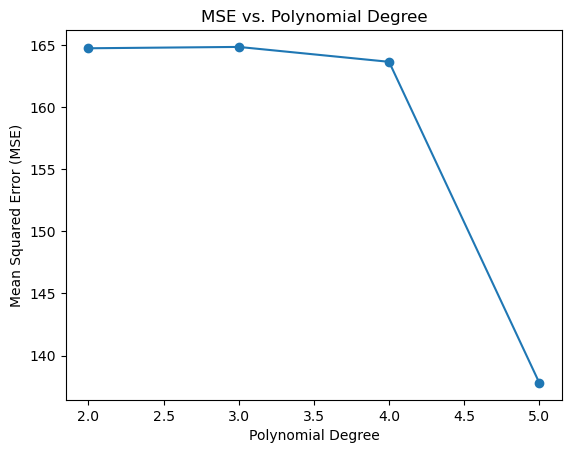

In [10]:
import matplotlib.pyplot as plt

# Extract the number of polynomial degrees tested
degrees = param_grid_poly['degree']  # Should match the number of degrees you tested

# Extract MSE for each polynomial degree 
mse_poly = -grid_poly.cv_results_['mean_test_score'][:len(degrees)]

plt.plot(degrees, mse_poly, marker='o')
plt.title('MSE vs. Polynomial Degree')
plt.xlabel('Polynomial Degree')
plt.ylabel('Mean Squared Error (MSE)')
plt.show()


# Task 7: Plot MSE vs. Gamma Value for RBF Kernel

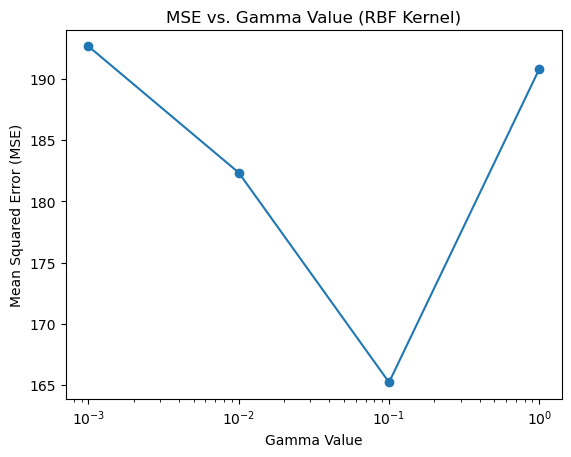

In [12]:
import matplotlib.pyplot as plt

# Extract the number of gamma values tested
gammas = param_grid_rbf['gamma']  # Should match the number of gamma values you tested

# Extract MSE for each gamma value (Make sure the shape matches)
mse_rbf = -grid_rbf.cv_results_['mean_test_score'][:len(gammas)]

plt.plot(gammas, mse_rbf, marker='o')
plt.title('MSE vs. Gamma Value (RBF Kernel)')
plt.xlabel('Gamma Value')
plt.ylabel('Mean Squared Error (MSE)')
plt.xscale('log')  # Gamma values are often represented on a log scale
plt.show()


# Task 8: Predictions and Scatter Plot

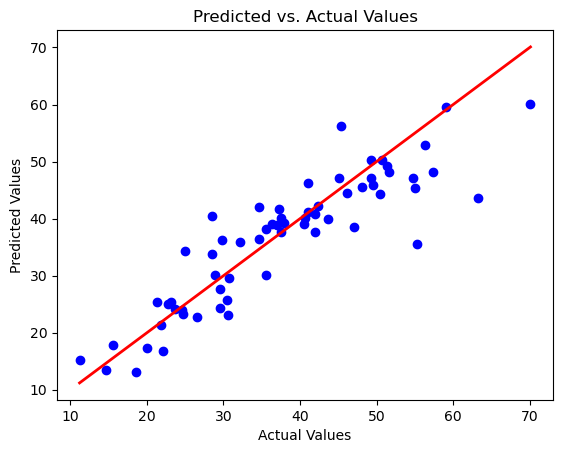

In [13]:
# Get the best models from the GridSearchCV
best_svr_poly = grid_poly.best_estimator_
best_svr_rbf = grid_rbf.best_estimator_

# Choose the best model based on validation score
if grid_poly.best_score_ > grid_rbf.best_score_:
    best_svr = best_svr_poly
else:
    best_svr = best_svr_rbf

# Make predictions on the test set
y_pred = best_svr.predict(X_test)

# Scatter plot of predicted vs actual values
plt.scatter(y_test, y_pred, color='blue')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', lw=2)  # Line of perfect prediction
plt.title('Predicted vs. Actual Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()
